In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle

from scipy.linalg import expm, eig, eigh, svd

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

from TFIM_generator import generate_TFIM_gates 
pi = np.pi

def print_matrix(mat):
    for i in mat:
        print("| ", end ="")
        for j in range(len(i)):
            if j != len(i)-1: print(f"{i[j]:10}", end="\t\t")
            else: print(i[j], end="")
        print(" |")

In [ ]:
def create_hamiltonian(parameters, show_steps=False):
    system = parameters['system']
    scale_factor = parameters['scaling']
    shifting = parameters['shifting']
    if 'particles' in parameters.keys(): qubits = parameters['particles']
    else: qubits = 2
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
    if system == "TFI":
        g = parameters['g']
        # construct the Hamiltonian
        # with Pauli Operators in Qiskit ^ represents a tensor product
        if show_steps: print("H = ", end='')
        for i in range(qubits-1):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i or j == i+1):
                    temp ^= Pauli('Z')
                else:
                    temp ^= Pauli('I')
            H += -temp.to_matrix()
            if show_steps: print("-"+str(temp)+" ", end='')
        # peroidic bound
        temp = Pauli('')
        for j in range(qubits):
            if (j == 0 or j == qubits-1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        H += -temp.to_matrix()
        if show_steps: print("-"+str(temp)+" ", end='')
        for i in range(qubits):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i):
                    temp ^= Pauli('X')
                else:
                    temp ^= Pauli('I')
            H += -g*temp.to_matrix()
            if show_steps: print("-"+str(g)+"*"+str(temp)+" ", end='')
        if show_steps: print("\n")
    elif system == "SPI":
        qubits = parameters['particles']
        J = parameters['J']
        def S(index, coupling):
            temp = Pauli('')
            for j in range(qubits):
                if j == index:
                    temp ^= Pauli(coupling)
                else:
                    temp ^= Pauli('I')
            return 1/2*temp.to_matrix()
        if show_steps: print("H = ", end='\n')
        for qubit in range(qubits-1):
            H += S(qubit, 'X')@S(qubit+1, 'X')
            H += S(qubit, 'Y')@S(qubit+1, 'Y')
            H += S(qubit, 'Z')@S(qubit+1, 'Z')
        H += S(qubits-1, 'X')@S(0, 'X')
        H += S(qubits-1, 'Y')@S(0, 'Y')
        H += S(qubits-1, 'Z')@S(0, 'Z')
        H *= J
        if show_steps: print(H)
    elif system == "HUB":
        qubits = parameters['particles']
        x = parameters['x']
        y = parameters['y']
        U = parameters['U']
        t = parameters['t']       
        # coupling portion
        Sd = np.array([[0,0],[1,0]])
        S = np.array([[0,1],[0,0]])
        I = np.eye(2)
        # op1 = np.kron(Sd, S)
        # op2 = np.kron(S, Sd)
        left_right_hopping_term = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
        for op in [Sd]:
            for site in range(qubits):
                curr_x = site%x
                curr_y = site//x%y
                # couple sites in square latice
                neighbors = []
                if curr_x != 0:   neighbors.append((site-1)%qubits)
                if curr_x != x-1: neighbors.append((site+1)%qubits)
                if curr_y != 0:   neighbors.append((site+x)%qubits)
                if curr_y != y-1: neighbors.append((site-x)%qubits)
                # print(site, neighbors)

                for neighbor in neighbors:
                    temp = [1]
                    for site_ in range(qubits):
                        # print(site_)
                        # print(site_ == site, site_ == neighbor)
                        if site_ == site: temp = np.kron(temp, op)
                        elif site_ == neighbor: temp = np.kron(temp, op.T)
                        else: temp = np.kron(temp, I)
                    left_right_hopping_term+=temp
        left_right_hopping_term *=-t

        # number operator portion
        op1 = np.kron(Sd, Sd)
        op2 = np.kron(S, S)
        num = op1@op2
        up_down_hopping_term = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
        for place in range(qubits-1):
            temp = [1]
            for index in range(qubits-1):
                if index == place: temp = np.kron(temp, num) 
                else: temp = np.kron(temp, I) 
            up_down_hopping_term+=temp
        up_down_hopping_term*=U

        H = up_down_hopping_term+left_right_hopping_term
    elif system[0:3] == 'H_2':
        from qiskit_nature.second_q.drivers import PySCFDriver
        from qiskit_nature.second_q.mappers import ParityMapper
        distance = parameters['distance']
        driver = PySCFDriver(
            atom=f'H .0 .0 .0; H .0 .0 {distance}',
            #unit=DistanceUnit.ANGSTROM,
            #charge=0,
            #spin=0,
            basis='sto3g'
        )
        molecule = driver.run()
        mapper = ParityMapper(num_particles=molecule.num_particles)
        fer_op = molecule.hamiltonian.second_q_op()
        tapered_mapper = molecule.get_tapered_mapper(mapper)
        H = tapered_mapper.map(fer_op)
    if show_steps:
        val, vec = eigh(H)
        print("Original eigenvalues:", val)
        print("Original eigenvectors:\n", vec)
        print("Original Matrix:")
        for i in H:
            for j in i:
                print(j, end = '\t\t')
            print()

    
    # scale eigenvalues of the Hamiltonian
    n = 2**qubits
    largest_eigenvalue = np.abs(eigh(H, eigvals_only=True, subset_by_index=[n-1,n-1])[0])
    if show_steps: print("Largest Eigenvalue =", largest_eigenvalue)
    parameters["r_scaling"] = largest_eigenvalue/scale_factor
    H *= scale_factor/largest_eigenvalue
    H += shifting*np.eye(n)

    if show_steps:
        val, vec = eigh(H)
        print("Scaled eigenvalues:", val)
        print("Scaled eigenvectors:\n", vec)
        min_eigenvalue = np.min(val)
        print("Lowest energy eigenvalue", min_eigenvalue); print()
    
    return H

def hadamard_test(controlled_U, statevector, W = 'Re', shots=100):
    aer_sim = AerSimulator()
    trans_qc = create_hadamard_test(aer_sim, controlled_U, statevector, W = W)
    counts = aer_sim.run(trans_qc, shots = shots).result().get_counts()
    return calculate_re(counts, shots)

def create_hadamard_test(backend, controlled_U, statevector, W = 'Re'):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(controlled_U.num_qubits-1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    qc.h(qr_eigenstate)
    # qc.initialize(statevector, qr_eigenstate)
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    trans_qc = transpile(qc, backend, optimization_level=3)
    return trans_qc

def calculate_re(counts, shots):
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas

In [63]:
def generate_s_k(Dt, K, parameters):
    if 'method_for_model' in parameters.keys(): method = parameters['method_for_model']
    else: method = 'F3C'

    s_k = []
    if method[0].upper() == 'Q':
        ham = create_hamiltonian(parameters)
    if method[0].upper() == 'F':
        g = parameters['g']
        coupling = 1
        particles = parameters['particles']
        if 'scaling' in parameters: scaling = parameters['scaling']
        else: scaling = 1
        gates = generate_TFIM_gates(particles, K, Dt, g, scaling, coupling, parameters['trotter'], '../f3cpp')
    for i in range(K):
        if method[0].upper() == 'Q':
            mat = expm(-1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = eigh(ham)
            statevector = vec[:,0]
        if method[0].upper() == 'F':
            controlled_U = gates[i]
            if g<0: statevector = Pauli('X'+'I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        if 'shots' in parameters: shots = parameters['shots']
        else: shots = 100
        s_k.append(hadamard_test(controlled_U, statevector, shots = shots))
    return s_k

def transpile_s_k(Dt, K, backend, parameters):
    if 'method_for_model' in parameters.keys(): method = parameters['method_for_model']
    else: method = 'F3C'
    trans_qcs = []
    if method[0].upper() == 'Q':
        ham = create_hamiltonian(parameters)
    if method[0].upper() == 'F':
        particles = parameters['particles']
        g = parameters['g']
        coupling = 1
        gates = generate_TFIM_gates(particles, K, Dt, g, parameters['scaling'], coupling, parameters['trotter'], '../f3cpp')
    for i in range(K):
        if method[0].upper() == 'Q':
            mat = expm(-1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = eigh(ham)
            statevector = vec[:,0]
        if method[0].upper() == 'F':
            controlled_U = gates[i]
            if g<0: statevector = Pauli('I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        trans_qcs.append(create_hadamard_test(backend, controlled_U, statevector))
    return trans_qcs

In [64]:
'''
k: number of columns
d: how much data per column
s_k: quantum data to create matrix
'''
def make_hankel(k, ref, s_k):
    m = k//3
    X = np.zeros((ref*m, k+1-m))
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] = s_k[i+j]
    return X

def least_squares_regularization(X, noise_threshold):
    U, sigma, V = svd(X)
    print('U'); print_matrix(U)
    print('sigma', sigma)
    print('V'); print_matrix(V)
    threshold = noise_threshold*max(sigma)
    print('threshold', threshold)
    for l in range(len(sigma)):
        print('sigma[l]', sigma[l], sigma[l] <= threshold)
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the singular value
            U[:,l] = 0   # remove the corresponding column
            V[l,:] = 0   # remove the corresponding row
    # sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    # for l in range(len(sigma)):
    #     sigma_mat[l][l] = sigma[l]
    return U, sigma, V

# this method is not verbose enough
def check_convergence(data, precision):
    if len(data) <= 11: return False
    for i in range(10):
        print(data[-i]-data[-i-1])
        if data[-i]/precision-data[-i-1]/precision > precision: return False
    return True

def make_d(alpha, k):
    return math.floor(alpha*(k+1))

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each iteration
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''
def ODMD(s_k, Dt, noise_threshold, max_iterations, alpha, precision=-1, est_E_0s = [], show_steps = False): 
    if show_steps: print("s_k:", s_k)
    k = -1
    while (True):
        k=k+1
        if k>max_iterations: break
        if show_steps: print("k =", k+1)
        d = make_d(alpha, k)
        # if d < 2: continue # 0xW and 1x1's break the svd
        if k < 3: est_E_0s.append(0); continue # svd breaks if k<3
        temp = make_hankel(k, 1, s_k)
        X = temp[:,:-1]
        Xprime = temp[:,1:]
        if show_steps: print("X"); print_matrix(X)
        if show_steps: print("Xprime") ; print_matrix(Xprime)
        U, S, Vh = svd(X, full_matrices=False)
        r = np.sum(S > noise_threshold * S[0]) # Rank truncation
        U = U[:, :r]
        if show_steps: print("singular values:", S)
        S = S[:r]
        if show_steps: print("filtered singular values:", S)
        V = Vh[:r, :].conj().T
        S_inv = np.diag(1/S)
        A = U.T @ Xprime @ V @ S_inv # atilde from ROEL_ODMD
        # A = Xprime @ V @ S_inv @ U.T
        if show_steps: print("A"); print_matrix(A)  
        eigenvalues,_ = eig(A)
        if show_steps: print("eigenvalues\n", eigenvalues)
        omega = np.sort(-np.imag(np.log(eigenvalues)/Dt))
        # omega = [i for i in omega if i!=-pi]
        # omega.append(0)
        if show_steps: print("omega =", omega)
        E_0 = omega[0]
        est_E_0s.append(E_0)
        if show_steps: print("E_0 =", E_0)
        if precision!=0 and check_convergence(est_E_0s, precision): break
    return E_0

In [65]:
parameters = {}

# COMPUTATION PARAMETERS
computation_type   = 'H' # computation_type OPTIONS: Simulation, Hardware
data_source        = 'F' # data_source OPTIONS: Generation (Only useable with Simulation), Files, Job (Only Usable with Hardware)

# ODMD Parameters
noise_threshold = 10**-2 # order of magnitute larger than actual noise
max_iterations  = 50
precision       = 0      # certainty threshold
alpha           = 1/2    # used to calculate matrix sizes

# SPECIFIC SYSTEM TYPE
parameters['system']     = 'TFIM' # OPTIONS: TFIM, SPIN, HUBBARD

# Generic System Parameters
parameters['particles']  = 8
parameters['time_steps'] = [1]*2+[.5]*2 # time steps to test use with ODMD
parameters['shots']      = 10**4
parameters['scaling']    = 3/4*pi
parameters['shifting']   = 0


# Transverse Field Ising Model Parameters
parameters['g'] = 4 # magnetic field strength (TFIM)
parameters['method_for_model'] = 'F3C' # OPTIONS: F3C, Qiskit
parameters['trotter'] = 1000

# Spin Model Parameters
parameters['J'] = 4 # coupling strength (SPIN)

# Hubbard Parameters
parameters['t'] = 1 # left-right hopping (HUBB)
parameters['U'] = 1 # up-down hopping (HUBB)
parameters['x'] = 2 # x size of latice (HUBB)
parameters['y'] = 1 # y size of latice (HUBB)

# H_2 Parameters
parameters['distance'] = .735


In [66]:
print(create_hamiltonian(parameters, show_steps=False))

[[-0.5799507 +0.j -0.28997535+0.j -0.28997535+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.28997535+0.j -0.28997535+0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.28997535+0.j  0.        +0.j -0.28997535+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ... -0.28997535+0.j
   0.        +0.j -0.28997535+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
  -0.28997535+0.j -0.28997535+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ... -0.28997535+0.j
  -0.28997535+0.j -0.5799507 +0.j]]


In [ ]:
# PREPROCESSING

method_for_model = parameters['method_for_model']
system = parameters['system']

system = system[0:3].upper()
parameters['system'] = system[0:3].upper()
computation_type = computation_type[0].upper()
method_for_model = method_for_model[0].upper()
data_source = data_source[0].upper()
# parameter checking (if there's an error change parameters in question)
assert(computation_type == 'S' or computation_type == 'H')
assert(not method_for_model[0].upper()=="F" or system=="TFIM")
assert(data_source == 'G' or data_source == 'F' or data_source == 'J')
assert(not (computation_type == 'S' and data_source == 'J'))
assert(not (computation_type == 'H' and data_source == 'G'))
assert(system == "TFI" or system == "SPI" or system == "HUB" or system == "H_2")
if system == 'HUB':
    x_in = 'x' in parameters.keys()
    y_in = 'y' in parameters.keys()
    if not x_in and not y_in:
        parameters['x'] = parameters['particles']
        parameters['y'] = 1
    elif not x_in: parameters['x'] = 1
    elif not y_in: parameters['y'] = 1
    x = parameters['x']
    y = parameters['y']
    assert(x>=0 and y>=0)
    assert(x*y == parameters['particles'])
elif system == 'SPI':
    assert(parameters['J']!=0)
elif system == 'H_2':
    parameters['particles']=1

time_steps = parameters['time_steps']
scaling    = parameters['scaling']
shifting   = parameters['shifting']

Ks = []
for time_step in time_steps:
    K = 2*max_iterations+1
    Ks.append(K)

# backend setup
if computation_type == 'H' or data_source == 'J':
    api_token = input("Enter API Token:")
    from qiskit_ibm_runtime import QiskitRuntimeService as QRS
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
else:
    backend = AerSimulator()
sampler = Sampler(backend)

# define a system for naming files
def make_filename(computation_type, max_iterations, parameters, time_step=-1):
    system = parameters['system'][0:3].upper()
    string = "comp="+computation_type+"_sys="+system
    string+="_n="+str(parameters['particles'])
    if system=="TFI":
        method_for_model = parameters['method_for_model'][0].upper()
        string+="_m="+method_for_model
        if method_for_model == 'F':
            string+="_trotter="+str(parameters['trotter'])
        string+="_g="+str(parameters['g'])
    elif system=="SPI":
        string+="_J="+str(parameters['J'])
    elif system=="HUB":
        string+="_t="+str(parameters['t'])
        string+="_U="+str(parameters['U'])
        string+="_x="+str(parameters['x'])
        string+="_y="+str(parameters['y'])
    elif system=="H_2":
        string+="_dist="+str(parameters['distance'])
    string+="_scale="+str(scaling)
    string+="_shift="+str(shifting)
    if time_step != -1: string+="_Dt="+str(time_step)
    string += "_maxitr="+str(max_iterations)
    return string

In [ ]:
# DATA
s_ks = []

def empty(filename):
    try:
        return os.path.getsize(filename) == 0
    except FileNotFoundError:
        return True

# save data when using files
if data_source == 'F':
    from qiskit import qpy
    import os
        
    for i in range(len(time_steps)):
        time_step = time_steps[i]
        K = Ks[i]
        filename = "Transpiled_Circuits/"+make_filename(computation_type, max_iterations, parameters, time_step=time_step)+".qpy"
        if empty(filename):
            print("Creating file for Dt =", time_step)
            trans_qcs = transpile_s_k(time_step, K, backend, parameters)
            with open(filename, "wb") as file:
                qpy.dump(trans_qcs, file)
        else:
            print("File found for Dt =", time_step)
    print()

# load/generate s_k data
if data_source == 'F':
    trans_qcs = []
    for time_step in time_steps:
        print("Loading data from file for Dt =", time_step)
        filename = "Transpiled_Circuits/"+make_filename(computation_type, max_iterations, parameters, time_step=time_step)+".qpy"
        with open(filename, 'rb') as file:
            qcs = qpy.load(file)
            trans_qcs.append(qcs)
    print()
    trans_qcs = sum(trans_qcs, []) # flatten list
    if computation_type == 'H': print("Sending Job")
    if computation_type == 'S': print("Running Circuits")
    job = sampler.run(trans_qcs, shots = parameters['shots'])
    # save variables into file with pickle
    with open("Jobs/"+str(job.job_id())+".pkl", "wb") as file:
        info = [computation_type, data_source, noise_threshold, max_iterations, precision, alpha, parameters]
        pickle.dump(info, file)
    results = job.result() # all time steps are put into a single job

    if computation_type == 'H': print("Recieved Data")
    print()
elif data_source == 'J':
    job_id = input("Enter Job ID:")
    print("Loading data from job")
    job = service.job(job_id)
    with open("Jobs/"+str(job_id)+".pkl", "rb") as file:
        [computation_type, data_source, noise_threshold, max_iterations, precision, alpha, parameters] = pickle.load(file)
    print("Loaded data from job")
    results = job.result()
    print()


# construct s_k
for i in range(len(time_steps)):
    time_step = time_steps[i]
    if data_source == 'G':
        print("Generating Data for Dt =", time_step)
        K = Ks[i]
        s_ks.append(generate_s_k(time_step, K, parameters))
    else:
        print("Calculating s_k for time step:", time_step)
        start = sum(Ks[0:i])
        result = results[start:(start+Ks[i])] # seperate the data needed for this iteration
        # print(start, start+Ks[i], result)
        # print(len(result))
        s_k = []
        for i in range(len(result)):
            raw_data = result[i].data
            cbit = list(raw_data.keys())[0]
            s_k.append(calculate_re(raw_data[cbit].get_counts(), parameters['shots']))
        # print(s_k)
        s_ks.append(s_k)

In [ ]:
# # contruct perfect dataset for dt = 1 for TFIM
# time_steps.append(1)
# pattern = [1,-np.sqrt(2)/2, 0, np.sqrt(2)/2, -1, np.sqrt(2)/2, 0, -np.sqrt(2)/2]
# maxdata = 2*max_iterations+1
# s_ks.append((pattern*(int(maxdata/len(pattern))+1))[0:maxdata])


In [ ]:
# plt.title("difference in datasets")
# for i in range(len(s_ks)-1):
#     w = np.array(s_ks[i])-np.array(s_ks[-1])
#     plt.plot(abs(w), label = f'data set {i}')
# plt.legend()
# plt.show()

In [ ]:
trials = []
results = []
for i in range(len(time_steps)):
    time_step = time_steps[i]
    print("Using data from time step:", time_step)
    est_E_0s = []
    # print(s_ks[i])
    # print(len(s_ks[i]))
    result = ODMD(s_ks[i], time_step, noise_threshold, max_iterations, alpha, precision=precision, est_E_0s = est_E_0s, show_steps=False) 
    print("Calculated Energy:", result)
    results.append(result)
    trials.append(est_E_0s)


Using data from time step: 1
Calculated Energy: -2.356187137394016
Using data from time step: 1
Calculated Energy: -2.3561257575899397
Using data from time step: 0.5
Calculated Energy: -2.356215883133069
Using data from time step: 0.5
Calculated Energy: -2.3563209283085556


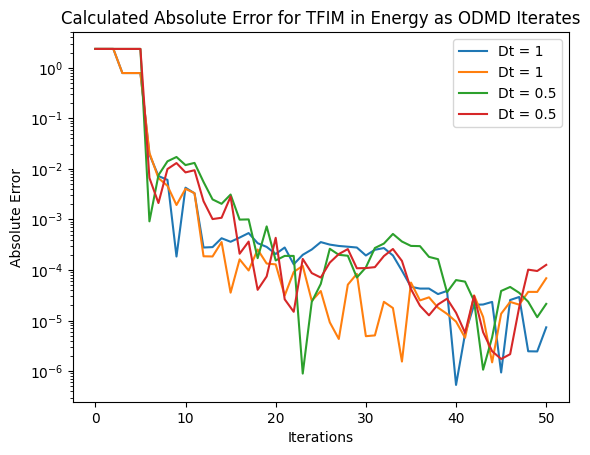

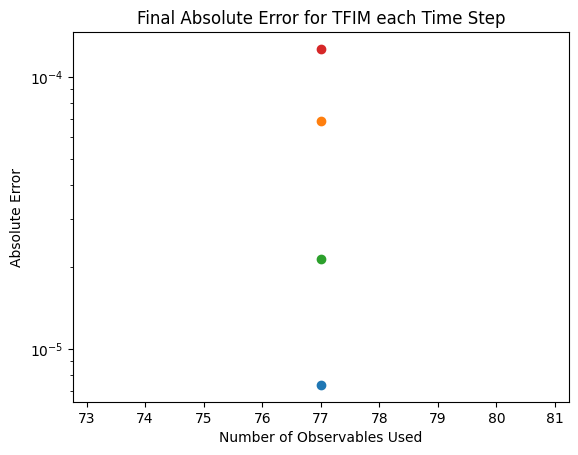

In [ ]:
real_E_0 = -3/4*pi
parameters["r_scaling"] = 1
for i in range(len(trials)):
    err = [parameters["shifting"]+parameters["r_scaling"]*abs(w-real_E_0) for w in trials[i]]
    # plt.plot(np.arange(0, 2*pi, time_steps[i])[0:len(trials[i])], err, label = 'Dt = '+str(time_steps[i]))
    # if i == len(trials)-1: label = 'Perfect Data'
    label = 'Dt = '+str(time_steps[i])
    plt.plot(range(len(err)), err, label = label)
plt.title("Calculated Absolute Error for "+system+" in Energy as ODMD Iterates")
plt.ylabel("Absolute Error")
plt.xlabel("Iterations")
plt.legend()
# plt.xlim([0,10])
# plt.ylim([0,10])
plt.yscale('log')
plt.savefig("Graphs/"+make_filename(computation_type, max_iterations, parameters)+"_shots"+str(parameters['shots'])+"_Abs_Error.png")
plt.show()

plt.title("Final Absolute Error for "+system+" each Time Step")
plt.xlabel("Number of Observables Used")
plt.ylabel("Absolute Error")
plt.yscale('log')
observables = [len(w)+make_d(1/2, len(w)) for w in trials]
for i in range(len(results)):
    plt.scatter([observables[i]], [abs(real_E_0-results[i])], label = 'Dt = '+str(time_steps[i]))
plt.savefig("Graphs/"+make_filename(computation_type, max_iterations, parameters)+"_shots"+str(parameters['shots'])+"_Final_Error.png")
# plt.legend()
plt.show()

In [ ]:
print(len(results))
print(time_steps)
print(results) 

4
[1, 1, 0.5, 0.5]
[np.float64(-2.356187137394016), np.float64(-2.3561257575899397), np.float64(-2.356215883133069), np.float64(-2.3563209283085556)]
